In [1]:
# Import Libraries
import serial
import numpy as np
import time

In [2]:
import serial.tools.list_ports

In [3]:
ports = serial.tools.list_ports.comports()

for port in ports:
    if port.serial_number == "85036313530351F0B141":
        arduino_port = port.device
    elif port.serial_number == "FT2OHLM4A":
        balance_port = port.device

In [4]:
M = [None] * 8
A = [None] * 8
C = [None] * 8
X = [None] * 7
P = [None] * 1
m = [None] * 1

In [5]:
def setupDispenser(dispenser,matrixComp,additiveComp):
    M[dispenser] = matrixComp
    A[dispenser] = additiveComp
    
def userInput(mass,matrixComp,A1Comp,A2Comp,A3Comp,A4Comp,A5Comp,A6Comp,A7Comp):
    m[0] = mass
    P[0] = matrixComp
    X[0] = A1Comp
    X[1] = A2Comp
    X[2] = A3Comp
    X[3] = A4Comp
    X[4] = A5Comp
    X[5] = A6Comp
    X[6] = A7Comp

In [6]:
# Matrix - Additive (M-A) relation in each dispenser
setupDispenser(0,0.9,0.1)
setupDispenser(1,0.9,0.1)
setupDispenser(2,0.9,0.1)
setupDispenser(3,0.9,0.1)
setupDispenser(4,0.9,0.1)
setupDispenser(5,0.9,0.1)
setupDispenser(6,0.9,0.1)
setupDispenser(7,0.9,0.1)

In [7]:
# USER INPUT: Desired proportion of PLA (P) and additives (X, Y, Z)
userInput(100,0.975,0,0.007,0.018,0,0,0,0)

In [8]:
# Compute pellet proportions for desired output
# Σ Ci*(Mi*P + Ai*X)
for i in range(1,8):
    C[i] = X[i-1]/A[i]

In [9]:
# Fill remaining with plastic
C[0] = P[0] - (C[1]*M[1] + C[2]*M[2] + C[3]*M[3] + C[4]*M[4] + C[5]*M[5] + C[6]*M[6] + C[7]*M[7])

In [10]:
# Check user inputs
tol = 1e-3
if(abs(1- (P[0] + X[0] + X[1] + X[2] + X[3] + X[4] + X[5] + X[6])) < tol):
    if(C[0] >= 0):
        print('Concentrations add up.')
        print('**************************************')
        print('C1 =', C[0])
        print('C2 =', C[1])
        print('C3 =', C[2])
        print('C4 =', C[3])
    else:
        print('WARNING: Concentrations add up, but they are not feasible.')
        print('**************************************')
        print('Check user input before continuing.')
else:
    print('WARNING: Concentrations do not add up.')
    print('**************************************')
    print('Check user input before continuing.')

Concentrations add up.
**************************************
C1 = 0.75
C2 = 0.0
C3 = 0.06999999999999999
C4 = 0.17999999999999997


In [11]:
concentrations = [C[0], C[1], C[2], C[3]]
minC = np.min([C for C in concentrations if C>tol])
#masked_concentrations = np.ma.masked_equal(concentrations, 0.0, copy=False)
#minC = masked_concentrations.min()
ratios = concentrations/minC 
print('The ratios for pellet dispensing will be: ', ratios)

The ratios for pellet dispensing will be:  [10.71428571  0.          1.          2.57142857]


In [12]:
balance = serial.Serial(port=balance_port, baudrate=9600, bytesize=serial.SEVENBITS,
                       parity=serial.PARITY_EVEN, stopbits=serial.STOPBITS_ONE)

def tare(balance):
    # Set the balance measurement to 0.0 g
    try:
        balance.write(b'T\r\n')
    except:
        balance = serial.Serial(port=balance_port, baudrate=9600, bytesize=serial.SEVENBITS,
                       parity=serial.PARITY_EVEN, stopbits=serial.STOPBITS_ONE)
        balance.write(b'T\r\n')


def calib(balance):
    # Calibrate the balance automatically
    try:
        balance.write(b'C\r\n')
    except:
        balance = serial.Serial(port=balance_port, baudrate=9600, bytesize=serial.SEVENBITS,
                       parity=serial.PARITY_EVEN, stopbits=serial.STOPBITS_ONE)
        balance.write(b'C\r\n')

def measure(balance):
    try:
        trash = balance.read_all()
        balance.write(b'B\r\n')
        reading = balance.readline()
        weight = float(reading[:10])
    except:
        balance = serial.Serial(port=balance_port, baudrate=9600, bytesize=serial.SEVENBITS,
                       parity=serial.PARITY_EVEN, stopbits=serial.STOPBITS_ONE)
        trash = balance.read_all()
        balance.write(b'B\r\n')
        reading = balance.readline()
        weight = float(reading[:10])
    return weight

In [13]:
arduino = serial.Serial(arduino_port, 9600)
time.sleep(2)

In [14]:
arduino.write(b'8')

1

In [22]:
measureAll = True
massAll = 0
mass = 0
mass1 = []
mass1.insert(0,0)
mass2= []
mass2.insert(0,0)
mass3= []
mass3.insert(0,0)
mass4= []
mass4.insert(0,0)
i = 0
times = []
times.insert(0,0)
start = time.time()
finish1 = []
finish1.insert(0,0)
finish2 = []
finish2.insert(0,0)
finish3 = []
finish3.insert(0,0)
finish4 = []
finish4.insert(0,0)

while measureAll == True:
    if C[0] > tol:
        if mass1[i] < ratios[0]*(i+1):
            measureNow = True
            tare(balance)
            time.sleep(2)
            arduino.write(b'3')
            while measureNow == True:
                mass = measure(balance)
                if mass + mass1[i] >= ratios[0]*(i+1):
                    arduino.write(b'8')
                    time.sleep(4)
                    mass = measure(balance)
                    measureNow = False
            massAll = massAll + mass
            mass1.insert(i+1,mass1[i]+mass)
            time.sleep(0.1)
        elif mass1[i] >= ratios[0]*(i+1):
            arduino.write(b'8')
        finish1.insert(i+1,time.time()-start)
        print("iteration ", i+1, "| t = ", finish1[i+1], "s | ", "mass 1: ", mass1[i+1])
            
    if C[1] > tol:
        if over2 < ratios[1]:
            measureNow = True
            tare(balance)
            time.sleep(2.5)
            arduino.write(b'3')
            while measureNow == True:
                mass = measure(balance)
                if mass >= ratios[1] - over2:
                    arduino.write(b'8')
                    time.sleep(7.5)
                    mass = measure(balance)
                    over2 = mass - (ratios[1] - over2)
                    measureNow = False
            massAll = massAll + mass
            mass2[i+1] = mass2[i] + mass
            time.sleep(0.1)
        elif over2 >= ratios[1]:
            arduino.write(b'8')
            over2 = 0
        print(mass2)
            
    if C[2] > tol:
        if mass3[i] < ratios[2]*(i+1):
            measureNow = True
            tare(balance)
            time.sleep(2)
            arduino.write(b'4')
            while measureNow == True:
                mass = measure(balance)
                if mass + mass3[i] >= ratios[2]*(i+1):
                    arduino.write(b'8')
                    time.sleep(4)
                    mass = measure(balance)
                    measureNow = False
            massAll = massAll + mass
            mass3.insert(i+1,mass3[i]+mass)
            time.sleep(0.1)
        elif mass3[i] >= ratios[2]*(i+1):
            arduino.write(b'8')
        finish3.insert(i+1,time.time()-start)
        print("iteration ", i+1, "| t = ", '%.2f' % finish3[i+1], "s | ", "mass 3: ", '%.3f' % mass3[i+1])
            
    if C[3] > tol:
        if mass4[i] < ratios[3]*(i+1):
            measureNow = True
            tare(balance)
            time.sleep(2)
            arduino.write(b'5')
            while measureNow == True:
                mass = measure(balance)
                if mass + mass4[i] >= ratios[3]*(i+1):
                    arduino.write(b'8')
                    time.sleep(4)
                    mass = measure(balance)
                    measureNow = False
            massAll = massAll + mass
            mass4.insert(i+1,mass4[i]+mass)
            time.sleep(0.1)
        elif mass4[i] >= ratios[3]*(i+1):
            arduino.write(b'8')
        finish4.insert(i+1,time.time()-start)
        print("iteration ", i+1, "| t = ", '%.2f' % finish4[i+1], "s | ", "mass 4: ", '%.3f' % mass4[i+1])
                      
    if massAll > m[0]:
        measureAll = False
        arduino.write(b'8')
    i = i + 1

iteration  1 | t =  179.9284543991089 s |  mass 1:  10.756
iteration  1 | t =  196.31 s |  mass 3:  1.122
iteration  1 | t =  216.94 s |  mass 4:  2.683
iteration  2 | t =  432.7366461753845 s |  mass 1:  21.434
iteration  2 | t =  447.75 s |  mass 3:  2.126
iteration  2 | t =  469.93 s |  mass 4:  5.224
iteration  3 | t =  737.5340297222137 s |  mass 1:  32.25
iteration  3 | t =  750.55 s |  mass 3:  3.142
iteration  3 | t =  783.54 s |  mass 4:  7.828
iteration  4 | t =  1021.7680349349976 s |  mass 1:  42.882
iteration  4 | t =  1034.98 s |  mass 3:  4.057
iteration  4 | t =  1055.77 s |  mass 4:  10.591
iteration  5 | t =  1289.201375246048 s |  mass 1:  53.659
iteration  5 | t =  1299.78 s |  mass 3:  5.062
iteration  5 | t =  1315.38 s |  mass 4:  13.316
iteration  6 | t =  1432.9976980686188 s |  mass 1:  65.035
iteration  6 | t =  1451.39 s |  mass 3:  6.022
iteration  6 | t =  1472.98 s |  mass 4:  15.685
iteration  7 | t =  1547.0061984062195 s |  mass 1:  75.023
iteration  7

In [ ]:
arduino.write(b'8')

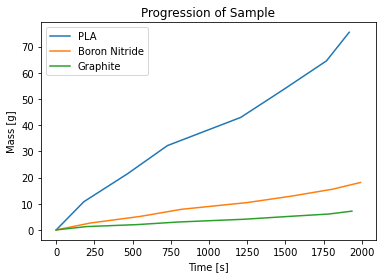

In [20]:
import matplotlib.pyplot as plt

plt.plot(finish1, mass1,label='PLA')
plt.plot(finish4,mass4,label='Boron Nitride')
plt.plot(finish3,mass3,label='Graphite')
plt.title("Progression of Sample")
plt.xlabel("Time [s]")
plt.ylabel("Mass [g]")
plt.legend()
plt.show()

In [23]:
massAll

100.56699999999998

In [18]:
error = X[1]abs((mass4[i] * 0.1)/(mass4[i] + mass1[i]))/(massAll)*100
accuracy = 100 - error
print('Accuracy:', '%.2f' % accuracy,'%')

rate = massAll/finish4[i]
rate = rate * 3600
print('Mass flow rate: ', '%.2f' % rate,'g/h')

Accuracy: 99.95 %
Mass flow rate:  289.89 g/h
